In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print

C:\Users\Franc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [52]:
data = pd.read_csv("source\Energy_Data_20200920_20240118.csv")

In [49]:
data.head()

,dtm,MIP,Solar_MW,Solar_capacity_mwp,Solar_installedcapacity_mwp,Wind_MW,SS_Price,boa_MWh,DA_Price
0,2020-09-20T00:00:00Z,20.06,0.0,2130.537493,2228.208777,996.284,2.50,0.0,32.17
1,2020-09-20T00:30:00Z,19.77,0.0,2130.537493,2228.208777,957.576,15.00,0.0,32.17
2,2020-09-20T01:00:00Z,28.68,0.0,2130.537493,2228.208777,941.044,47.95,0.0,32.00
3,2020-09-20T01:30:00Z,28.97,0.0,2130.537493,2228.208777,964.366,29.13,0.0,32.00
4,2020-09-20T02:00:00Z,28.19,0.0,2130.537493,2228.208777,918.432,28.95,0.0,31.99


In [3]:
data.isna().sum()

dtm                              0
MIP                            424
Solar_MW                        75
Solar_capacity_mwp               0
Solar_installedcapacity_mwp      0
Wind_MW                        103
SS_Price                         0
boa_MWh                        103
DA_Price                         0
dtype: int64

# Outliers 

## Visualisation  

As we can see on these charts, most of the columns have a skewed gaussian (mean is different from median)

MIP........................... : Mean 126.35.... vs Median 100.82.... std = 94.39.....

Solar_MW...................... : Mean 229.46.... vs Median 0.02...... std = 379.61....

Solar_capacity_mwp............ : Mean 2213.60... vs Median 2167.49... std = 128.53....

Solar_installedcapacity_mwp... : Mean 2341.44... vs Median 2295.21... std = 145.72....

Wind_MW....................... : Mean 574.89.... vs Median 514.08.... std = 438.39....

SS_Price...................... : Mean 127.41.... vs Median 102.50.... std = 128.90....

boa_MWh....................... : Mean -1.57..... vs Median 0.00...... std = 22.15.....

DA_Price...................... : Mean 130.25.... vs Median 101.31.... std = 99.83.....

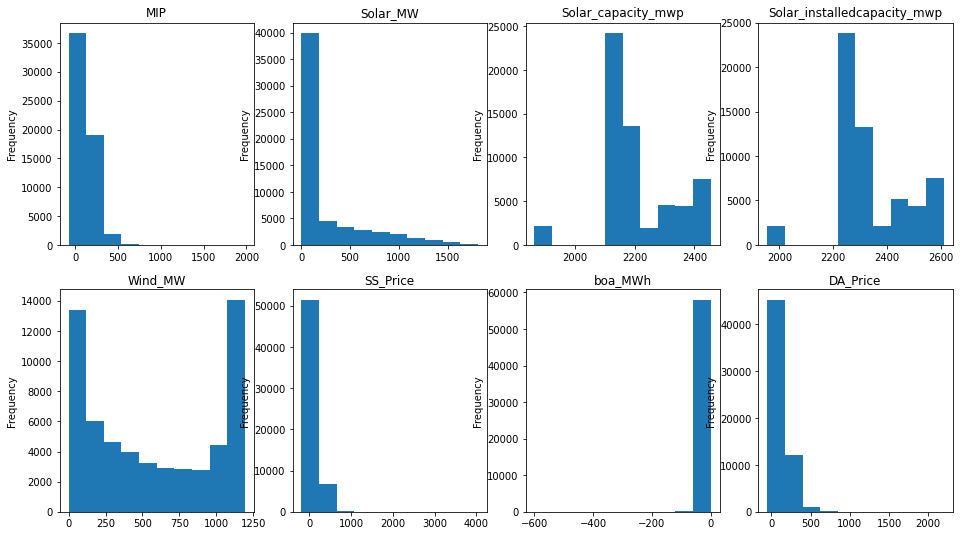

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 9))

for i,col in enumerate(data.columns[1:]) : 
    data[col].plot(kind='hist', ax=axes.flat[i])
    axes.flat[i].set_title(col)

    print(f"{col:.<30} : Mean {data[col].mean():.<10.2f} vs Median {data[col].median():.<10.2f} std = {data[col].std():.<10.2f}")

<AxesSubplot:>

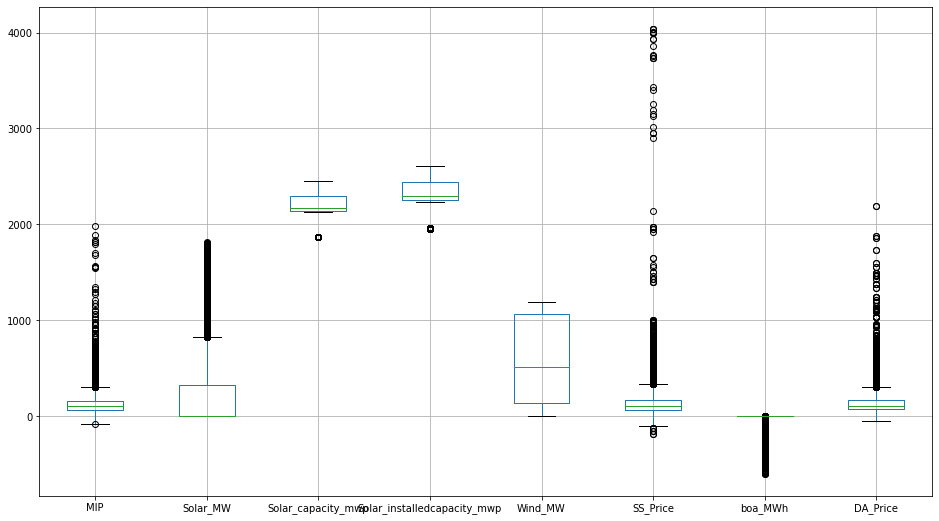

In [10]:
fig, ax = plt.subplots(figsize=(16, 9))

data.boxplot()

## Remove outliers  
If we remove outliers, we lose ~25% of our dataset

In [61]:
def remove_outliers(df: pd.DataFrame, col: str):
    Q3 = df[col].quantile(0.75)
    Q1 = df[col].quantile(0.25)
    
    IQR = Q3 - Q1
    upper = Q3 + IQR * 1.5 + 0.001 # boa_MWh have 0 as Q1 and Q3 
    lower = Q1 - IQR * 1.5 - 0.001
    # print(f"{col} : {lower}-{upper}")
    res = df[ (df[col] < upper) & (df[col] > lower) ]
    return res

In [64]:
data = pd.read_csv("source\Energy_Data_20200920_20240118.csv")
print(f"before : {data.shape}")
for col in data.columns[1:]:
    data = remove_outliers(data, col)
print(f"after : {data.shape}")
# data.to_csv() save ?


before : (58368, 9)

after : (44389, 9)

# Missing value repartition  
Through these plots, we can observe that there are "batches" of missing values which are spread randomly, maybe we should consider those batches independantly.  
Also we can see that **Wind_MW** and **boa_MWh** have the same missing values.

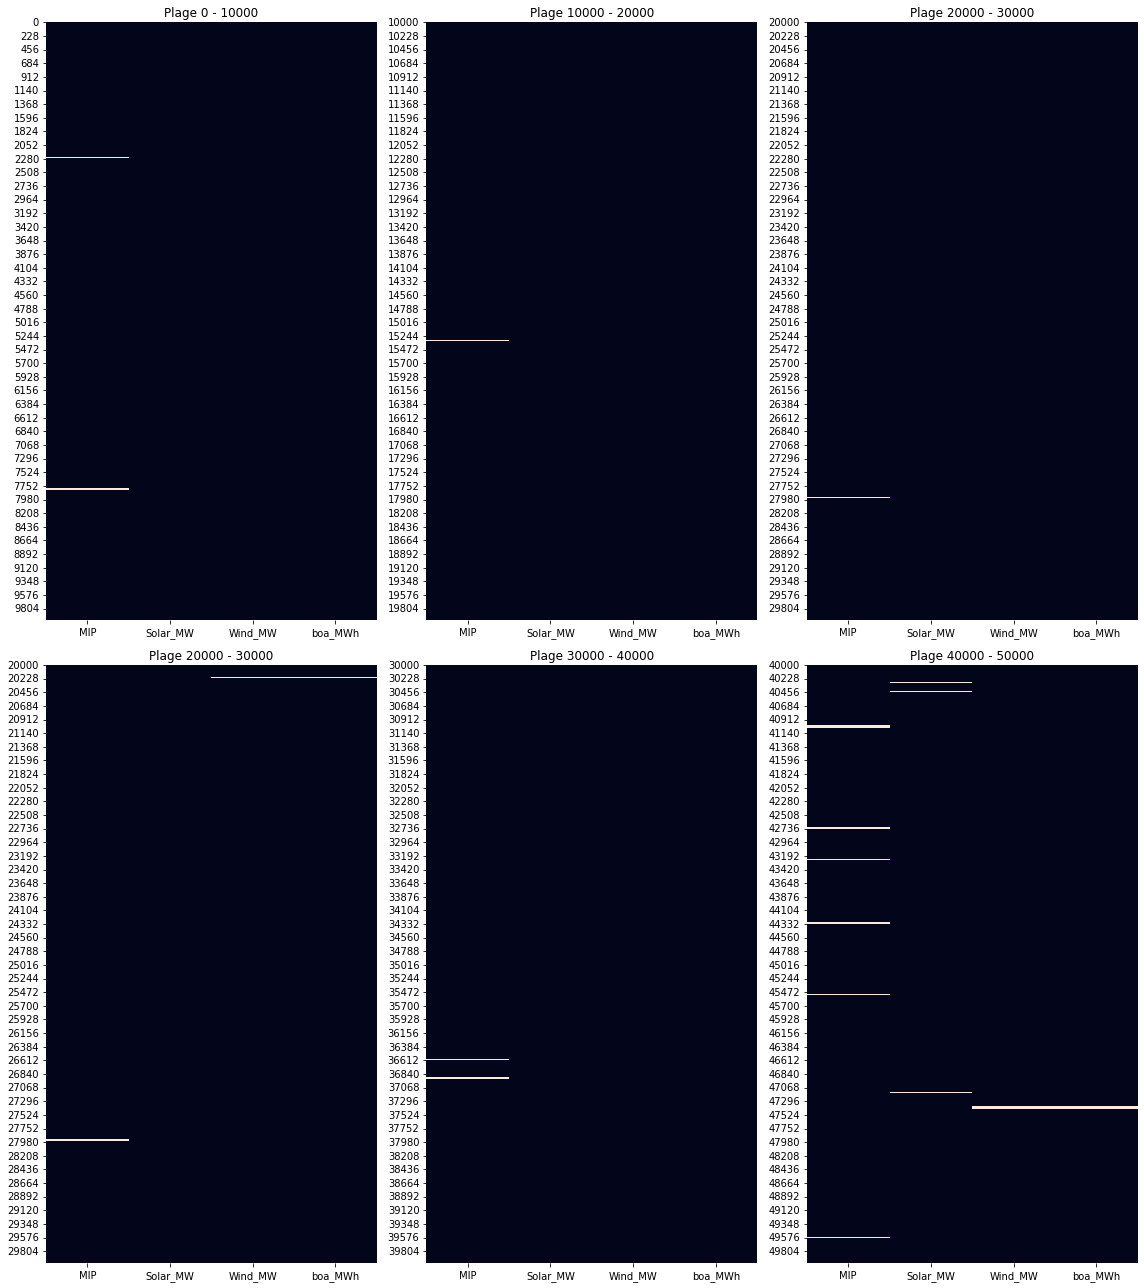

In [30]:
# # Big figures
# fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 50))

# Small figures
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 18))

missing_col = ["MIP", "Solar_MW", "Wind_MW", "boa_MWh"]

for i, ax_row in enumerate(axes):
    for j, ax_col in enumerate(ax_row):
        start = 10000 * (i*2 + j)
        end = 10000 * (i*2 + j + 1)
        
        if end > len(data):
            end = len(data)
        
        sns.heatmap(data[missing_col].iloc[start:end].isnull(), cbar=False, ax=ax_col)
        ax_col.set_title(f'Plage {start} - {end}')

plt.tight_layout()
plt.show()


On peut voir que les données manquantes ne sont pas réparties aléatoirement, en effet, elles se regroupent par paquets plus ou moins grand  
On remarque aussi que les variables Wind_MW et boa_MWh on les mêmes données manquantes  

# Average Fill
```energy_avgfill.csv```

In [5]:
def avg_fill(df: pd.DataFrame, col : str):
    avg = df[col].mean()
    
    df[col] = df[col].fillna(avg, inplace=False)
    return df

In [6]:
data_filled = pd.DataFrame(data, copy=True)
for col in missing_col:
    data_filled = avg_fill(data_filled, col)

if input("Save ? Y/N").lower() == 'y':
    data_filled.to_csv("energy_avgfill.csv")
data_filled.isna().sum()

dtm                            0
MIP                            0
Solar_MW                       0
Solar_capacity_mwp             0
Solar_installedcapacity_mwp    0
Wind_MW                        0
SS_Price                       0
boa_MWh                        0
DA_Price                       0
dtype: int64

# Hot-deck imputation

# Fill by groups